In [ ]:
!unzip Dataset\ \(2\).zip  -d Dataset


In [ ]:
 # Import Libraries

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image


In [ ]:
train_dir = '/content/Dataset/Dataset'

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20,
    zoom_range=0.2, horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), class_mode='categorical')

Found 148 images belonging to 3 classes.


In [ ]:
# Create Transfer Learning Model
# [ ResNet + ImageNet] + HL1 + HL2 + Output Layer

In [ ]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet',
                                               include_top=False,
                                               input_shape=(224, 224, 3))
base_model.trainable = False  # freeze the base

# Add custom layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),       # Hidden Layer Nodes = 128
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense( 3 , activation='softmax')      # Output Layer Nodes = 3
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compile Model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train Model
model.fit(train_generator , epochs= 10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4980 - loss: 1.1586
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8793 - loss: 0.3184
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9783 - loss: 0.0809
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9760 - loss: 0.0690
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 1.0000 - loss: 0.0160
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9711 - loss: 0.0630
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 1.0000 - loss: 0.0222
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9895 - loss: 0.0220
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9889 - loss: 0.0421
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9963 - loss: 0.0164


In [ ]:
model.save('model.h5')

**Model Deployment **

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
model = load_model("model.h5")
class_names = list(train_generator.class_indices.keys())

In [ ]:
class_names

['Books', 'Bottle', 'Mug']

In [ ]:
# Preprocess Image

def predict_image(img):
    img = img.resize((224, 224))                         # Resizing Image to (224, 224)
    img_array = image.img_to_array(img) / 255.0          # Scaling it
    img_array = np.expand_dims(img_array, axis=0)        # Expanding Dimension
    prediction = model.predict(img_array)                # Predicting Outcome
    return class_names[np.argmax(prediction[0])]

In [ ]:
# Test Image

im1 = Image.open('/content/test1.jpg')

predict_image(im1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


'Books'

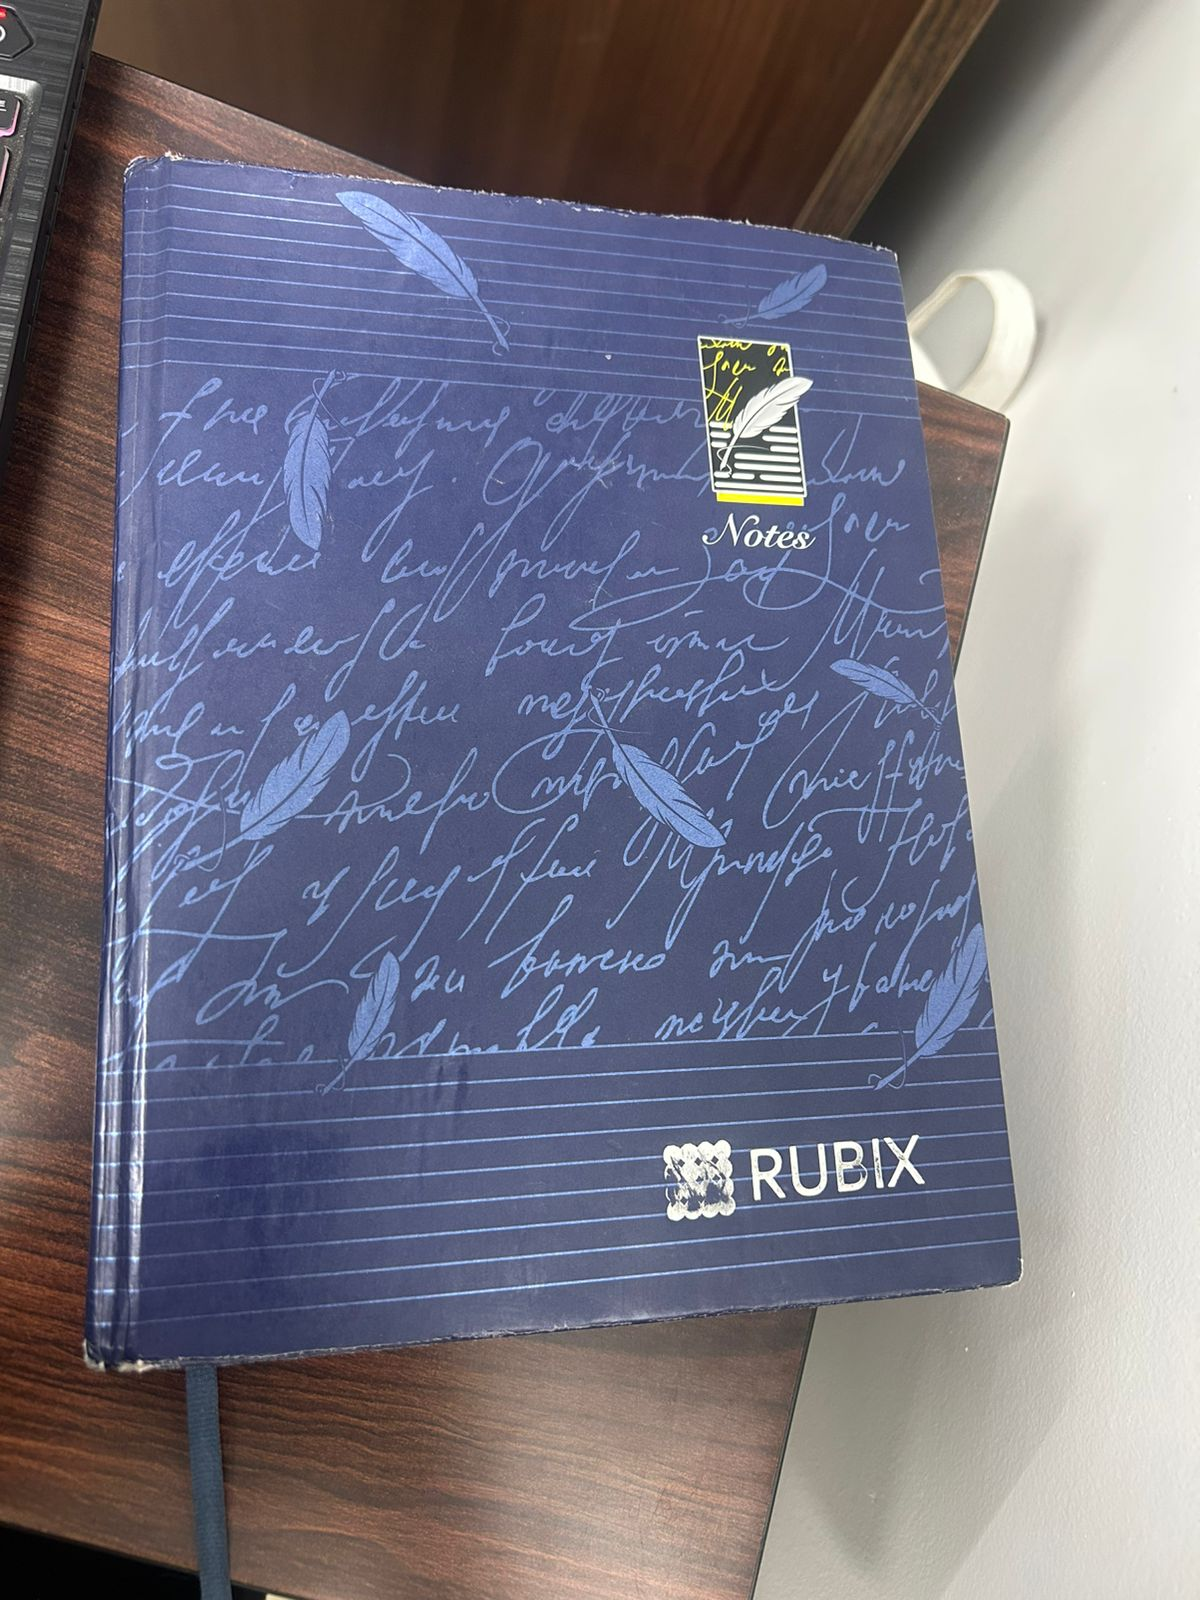

In [ ]:
im1

In [ ]:
gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=1)
).launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e90f78828bb4f513d3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
